In [1]:
import zemberek_grpc.language_id_pb2 as z_langid
import zemberek_grpc.language_id_pb2_grpc as z_langid_g
import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g
import zemberek_grpc.preprocess_pb2 as z_preprocess
import zemberek_grpc.preprocess_pb2_grpc as z_preprocess_g
import zemberek_grpc.morphology_pb2 as z_morphology
import zemberek_grpc.morphology_pb2_grpc as z_morphology_g
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import re
import sys
import nltk
import grpc
import string
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.utils import resample
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Bidirectional, Dense, Dropout, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Zemberek Preprocessing

In [2]:
# Defining functions that perform language detection, tokenization, normalization and morphological analysis
# by connecting to ZEMBEREK-GRPC based language processing services

channel = grpc.insecure_channel('localhost:6789')

langid_stub = z_langid_g.LanguageIdServiceStub(channel)
normalization_stub = z_normalization_g.NormalizationServiceStub(channel)
preprocess_stub = z_preprocess_g.PreprocessingServiceStub(channel)
morphology_stub = z_morphology_g.MorphologyServiceStub(channel)

def find_lang_id(i):
    response = langid_stub.Detect(z_langid.LanguageIdRequest(input=i))
    return response.langId

def tokenize(i):
    response = preprocess_stub.Tokenize(z_preprocess.TokenizationRequest(input=i))
    return response.tokens

def normalize(i):
    response = normalization_stub.Normalize(z_normalization.NormalizationRequest(input=i))
    return response

def analyze(i):
    response = morphology_stub.AnalyzeSentence(z_morphology.SentenceAnalysisRequest(input=i))
    return response;

def fix_decode(text):
    """Pass decode."""
    if sys.version_info < (3, 0):
        return text.decode('utf-8')
    else:
        return text

In [3]:
# Loading the raw sentiment dataset.
file_path = 'sentiment_data.csv'
df = pd.read_csv(file_path)

# Displaying the first few rows of the raw dataset.
df.head()

,text,sentiment
0,Geçtiğimiz hafta Covid-19’a ilişkin endişeler ...,neg
1,Güne satıcılı başlayan sonrasında gün içi topa...,neg
2,Geçtiğimiz hafta ABD 10 yıllık tahvil faizleri...,neg
3,Ukrayna krizi kaynaklı tedirginlik küresel piy...,neg
4,ABD ve Birleşik Krallık hisse senedi piyasalar...,neg


# TEXT PREPROCESS  

In [4]:
def text_preprocess(raw_text):
    special_terms = {"çovid-19’a", "bist", "bist-100"}
    
    # Normalizing the input.
    normalized_text = " ".join([
        word if word.lower() in special_terms else normalize(word).normalized_input
        for word in raw_text.split()
    ])

    # Applying Tokenization.
    tokens = tokenize(normalized_text)

    # Removing stopwords, numbers, and punctuations.
    stop_words = {"ve", "bir", "bu", "şu", "ile", "için", "çok", "ama", "da", "de", "ki", "eğer"}
    clean_tokens = [
        token.token.lower() for token in tokens
        if token.token not in string.punctuation
        and not re.match(r'^[\d\.,%-]+$', token.token)  # Sayılar, yüzde ve özel karakterler (örn. %, -) olanları filtreler
        and token.token.lower() not in stop_words
    ]

    # Applying Lemmatization.
    lemmatized_tokens = []
    for token in clean_tokens:
        if token in special_terms:  # Applying lemmatization to special terms.
            lemmatized_tokens.append(token)
        else:
            analysis_result = analyze(token)
            for result in analysis_result.results:
                lemmatized_tokens.append(result.best.lemmas[0] if result.best.lemmas else token)

    # Returning cleaned and lemmatized text by combining the results.
    return ' '.join(lemmatized_tokens)

### Data Samples

In [5]:
print(df["text"][0])

Geçtiğimiz hafta Covid-19’a ilişkin endişeler ve piyasalardaki fiyat düzeltme beklentisi gibi faktörler neticesinde hisse senetlerinde risk iştahının zayıf seyrettiğini gözlemledik. Buna bağlı olarak BIST-100 2021 başından bu yana kazançlarını neredeyse sıfırlarken, banka hisselerinde yıl başından bu yana gördüğümüz kayıplar %8’i aştı. Yeni haftanın gündeminde Ocak ayı enflasyon verisi ve şirketlerden gelen 4. çeyrek kârları en önemli yeri tutuyor. Borsanın haftanın ilk gününde yurtdışı eğilimden etkilenerek haftaya hafif alıcılı bir başlangıç yapmasını bekliyoruz.


In [6]:
print(df["text"][10])

Dün BIST’deki düşüş üst üste sekizinci gününe girdi. Dünkü %5 üzeri kayıpla endeks yılbaşına göre %14’ün üzerinde gerilemiş oldu. Banka hisselerindeki kayıp ise dün %8’i, yılbaşına göre %23’ü buldu. Dünkü satışlarda belirgin bir haber akışı öne çıkmadı. Tarihsel veri bu denli sert düşüşler sonrası tepki geldiğini gösteriyor. Dünkü düşüş sonrası BIST-100 endeksi 100 günlük hareketli ortalamasının sadece %3.9 üzerinde seyrediyor. Endeks 18 Ekim 2021’den bu yana ortalamanın üzerinde kalmayı başardı. Ortalamaya bu denli yakınlaşması ise en son Temmuz 2022’de gerçeklemişti. Yılbaşından bu yana satışların devam etmesi 2022 yılındaki yüksek getirinin realizasyonu ve 2023’teki belirsizlik endişesine yorumlanabilir. Dün yurtdışı tarafta ise FED’in beklentiler paralelinde gelen faiz artışı sonrası temkinli iyimser bir hava hakimdi. Yurtdışı tarafta borsa endeksleri günü genelde artıda kapattı. Haber akışı açısından yarın açıklanacak Ocak ayı enflasyon verileri önem taşıyor. BIST’de bugün dünkü s

In [7]:
print(df["text"][1000])

Veri trafiği hızlanıyor. Tatil sonrası veri akışı artıyor. Avrupa'da Hizmet PMI, ABD'de  İmalat ISM verileri ve Fed toplantı tutanakları bugün izlenecekler arasında yer almakta. Yıla pozitif  başlangıç yapan BİST-100 endeksinde ise 5700-5800 direnç bölgesi ön planda kaldı. Dün bu direnç  bölgede kar satışları gördük. Kısa vadede kar satışları açısından 5600-5550 aralığını takip ediyoruz.  5550 bölgesi üzerinde gündeme gelebilecek tepki alımları adına izlediğimiz dirençler sırasıyla 5670- 5710-5800.


In [8]:
# Applying Text Preprocessing to the raw dataset.
df["text"] = df["text"].apply(text_preprocess)

df.head()

,text,sentiment
0,geç hafta çovid-19’a ilişkin endişe piyasa fiy...,neg
1,gün sat başla sonra gün iç toparla artı geçen ...,neg
2,geç hafta abd yıllık tahvil faiz gözle sıçra k...,neg
3,ukrayna kriz kaynak tedirgin küresel piyasa et...,neg
4,abd birleşik krallık hisse senet piyasa kapalı...,neg


### Preprocessed Data Samples

In [9]:
print(df["text"][0])

geç hafta çovid-19’a ilişkin endişe piyasa fiyat düzel beklenti gibi faktör netice hisse senet risk iştah zayıf seyret gözlemle bu bağ ol bist-100 baş yan kazanç neredeyse sıfırla banka hisse yıl baş yan gör kayıp %8 aş yeni hafta gündem ocak ayı enflasyon veri şirket gel çeyrek kar en önem yer tut borsa hafta ilk gün yurtdışı eğilim etkile hafta hafif al başlangıç yap bekle


In [10]:
print(df["text"][10])

dün UNK düş üst üste sekizinci gün gir dün üzeri kayıp endeks yılbaşı göre %14 üzeri gerile ol banka hisse kayıp iş dün %8 yılbaşı göre %23 bul dün sat belirgin haber ak one çık tarih veri denli sert düş sonra tepki gel göster dün düş sonra bist-100 endeks günlük hareket ortalama sadece üzeri seyret endeks ekim 2021 yan ortalama üzeri kal başar ortalama denli yakın iş en sen temmuz 2022 gerçekle yılbaş yan sat devam et yıl yüksek getiri realizasyon 2023 belirsiz endişe yorumla dün yurtdışı taraf iş fed beklenti paralel gel faiz artı sonra temkin iyimser hava haki yurtdışı taraf borsa endeks gün genelde artı kapa haber ak açı yarın açıkla ocak ayı enflasyon veri önem taşı UNK bugün dün UNK miktar tepki gel ancak piyasa bu devam konu temkin hareket UNK düşün


In [11]:
print(df["text"][1000])

veri trafik hız tatil sonra veri ak art avrupa hizmet pmı abd imalat UNK veri fed toplantı tutanak bugün izle ara yer al yıl pozitif başlangıç yap bist-100 endeks iş direnç bölge on plan kal dün direnç bölge kar sat gör kısa vade kar sat açı aralık takip et bölge üzeri gündem gel tepki alım ad izle direnç sıra


In [12]:
# Saving preprocessed data to a new CSV file to save time.
output_file_path = 'pre_sentiment_data.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Processed data saved as: {output_file_path}")

Processed data saved as: pre_sentiment_data.csv


In [13]:
# Changing the data frame with preprocessed data.
file_path = 'pre_sentiment_data.csv'
df = pd.read_csv(file_path)

# Displaying the first few rows of the new dataframe.
df.head()

,text,sentiment
0,geç hafta çovid-19’a ilişkin endişe piyasa fiy...,neg
1,gün sat başla sonra gün iç toparla artı geçen ...,neg
2,geç hafta abd yıllık tahvil faiz gözle sıçra k...,neg
3,ukrayna kriz kaynak tedirgin küresel piyasa et...,neg
4,abd birleşik krallık hisse senet piyasa kapalı...,neg


### Sentiment distribution (negative and positive)

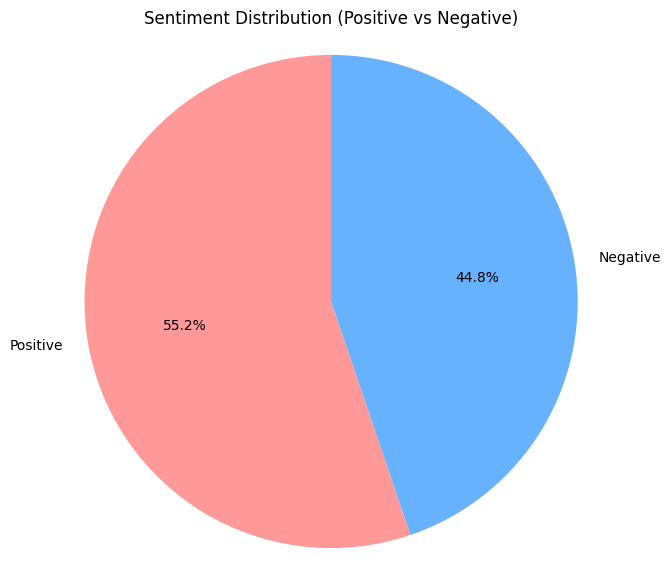

In [14]:

sentiment_distribution = df["sentiment"].value_counts()

# Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(sentiment_distribution, labels=["Positive", "Negative"], autopct='%1.1f%%', startangle=90, colors=["#FF9999", "#66B2FF"])
plt.title('Sentiment Distribution (Positive vs Negative)')
plt.axis('equal')
plt.show()

# WORD2VEC EMBEDDING  

In [15]:
# Splitting text into tokens.
sentences = [text.split() for text in df['text']]

# Creating and training the Word2Vec model:
word2vec_model = Word2Vec(
    sentences=sentences,
    vector_size=100,        # -----------------> Change VECTOR Size <-----------------
    window=5,               # -----------------> Change Window Size <-----------------
    min_count=2,            # ------------> Change Minimum Word Frequency <-----------
    workers=4,              # ------------> Change Number of Processors <-------------
    sg=1                    # ------------> (1 = Skip-gram, 0 = CBOW) <---------------
)

# Displaying the vector of an example word:
print(word2vec_model.wv['banka'])  # -----------------> Change Example Word <-----------------

# Saving the model.
word2vec_model.save("word2vec_model.model")
print("\nWord2Vec model saved as 'word2vec_model.model'")

[ 0.20626007 -0.04971341  0.03557171  0.27297124 -0.17374884 -0.22931683
  0.09127041  0.28539354 -0.126714    0.08068453 -0.1279823  -0.23399043
 -0.26682264 -0.26179722 -0.20955881 -0.12152415 -0.09946585 -0.46194035
 -0.11488605 -0.24758251  0.28485158 -0.15841468 -0.07148001 -0.00631528
 -0.19324376  0.00130231 -0.33702087 -0.03022442  0.2888558  -0.3179784
  0.34915113  0.33339     0.42003042 -0.14328915 -0.07005659 -0.17806858
  0.2924282   0.29795355  0.12765637 -0.00461084 -0.00192786 -0.15024443
  0.04095566  0.24539033 -0.30669054  0.04294789 -0.2543391  -0.2584963
  0.25510052  0.01883505 -0.19553892  0.0810427   0.32993895  0.12305178
  0.21367535  0.14399956 -0.0980177  -0.40320104 -0.4224043   0.39634576
 -0.10716596 -0.13294809  0.66087884  0.09610549  0.29483938 -0.00399594
 -0.311963    0.09796407 -0.18005727 -0.04446014 -0.05401109 -0.11859277
  0.3362762   0.32192168  0.27256092  0.05928766  0.01145935  0.26169428
  0.15879953  0.05078218 -0.08298895  0.06954476 -0.3

In [16]:
# Encoding labels as positive & negative.
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

# Splitting the data into Training and Test sets.
X = df['text'].values
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Importing Word2Vec model.
word2vec_model = Word2Vec.load("word2vec_model.model")

# Converting words to Word2Vec vectors.
def text_to_word2vec(text, model, vector_size=100): # ----------> Change VECTOR Size Here! <----------
    return [model.wv[word] if word in model.wv else np.zeros(vector_size) for word in text.split()]

X_train_vec = [text_to_word2vec(text, word2vec_model) for text in X_train]
X_test_vec = [text_to_word2vec(text, word2vec_model) for text in X_test]

max_length = 100  # Maximum sentence length.

# LSTM (LONG SHORT-TERM MEMORY)

In [17]:
# Manual padding:
def pad_word_vectors(sequences, max_length, vector_size=100): # ------> Change VECTOR Size Here! <-----
    padded_sequences = np.zeros((len(sequences), max_length, vector_size))
    for i, seq in enumerate(sequences):
        for j, word_vec in enumerate(seq):
            if j < max_length:
                padded_sequences[i, j] = word_vec
    return padded_sequences

X_train_pad = pad_word_vectors(X_train_vec, max_length)
X_test_pad = pad_word_vectors(X_test_vec, max_length)

# Displaying the padded data.
print("X_train_pad shape:", X_train_pad.shape)  # (num_samples, max_sequence_length, embedding_dim)
print("X_test_pad shape:", X_test_pad.shape)

#-----------------------------------------------------------------------------------------------------#

# Making the model:
model = Sequential()

# Adding the Input layer:
model.add(Input(shape=(max_length, 100)))  # --------------> Change VECTOR Size Here! <---------------

# Adding the Bidirectional LSTM Layer:
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=False)))

# Adding the Dropout Layer:
model.add(Dropout(0.5))

# Adding the Output layer: (sigmoid activation function for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compiling the model:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# (Using class weights if there is a class imbalance.)
class_weights = {0: 1., 1: 2.}

# Training the model:
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test), class_weight=class_weights)

# Evaluating the accuracy of the model:
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Making predictions:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating Precision, Recall, and F1-Score:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the results:
print(f'\nWord2Vec LSTM Model Test Accuracy: {accuracy * 100:.2f}%')
print(f"Word2Vec LSTM Model Test Precision: {precision:.2f}") # True positive predictions among all positive predictions.
print(f"Word2Vec LSTM Model Test Recall: {recall:.2f}") # True positive predictions among all actual positive instances
print(f"Word2Vec LSTM Model Test F1-Score: {f1:.2f}")

X_train_pad shape: (1364, 100, 100)
X_test_pad shape: (342, 100, 100)
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 0.5534 - loss: 0.9728 - val_accuracy: 0.5205 - val_loss: 0.7077
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5357 - loss: 0.8962 - val_accuracy: 0.5234 - val_loss: 0.6747
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.6102 - loss: 817065.3125 - val_accuracy: 0.5819 - val_loss: 0.6516
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6026 - loss: 0.8894 - val_accuracy: 0.5263 - val_loss: 1.2803
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.5644 - loss: 2.1086 - val_accuracy: 0.5234 - val_loss: 0.6689
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5175 - loss: 0.6735
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step 

Word2Vec LSTM Model Test Accuracy: 52.34%
Word2Vec LSTM Model Test Precision: 0.52
Word2Vec LSTM Model Test Recall: 0.98
Word2Vec LSTM Model Test F1-Score: 0.68


# RNN (RECURRENT NEURAL NETWORK) 

In [18]:
# Keras Based Padding:
X_train_pad = pad_sequences(X_train_vec, maxlen=max_length, dtype='object', padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_vec, maxlen=max_length, dtype='object', padding='post', truncating='post')

# Editing the data to be in the correct 3D format.
X_train_pad = np.array([np.array(sentence) for sentence in X_train_pad], dtype='float32')
X_test_pad = np.array([np.array(sentence) for sentence in X_test_pad], dtype='float32')

# Displaying the padded data.
print(f"X_train_pad shape: {X_train_pad.shape}") # (num_samples, max_sequence_length, embedding_dim)
print(f"X_test_pad shape: {X_test_pad.shape}")

#-----------------------------------------------------------------------------------------------------#

# Making the model:
model = Sequential()

# Adding the Input layer:
model.add(Input(shape=(max_length, 100)))  # --------------> Change VECTOR Size Here! <---------------

# Adding the RNN Layer:
model.add(SimpleRNN(128, activation='relu', return_sequences=False))

# Adding the Dropout Layer:
model.add(Dropout(0.5))

# Adding the Output layer: (sigmoid activation function for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compiling the model:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model:
model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Evaluating the accuracy of the model:
loss, accuracy = model.evaluate(X_test_pad, y_test)

# Making predictions:
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculating Precision, Recall, and F1-Score:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing the results:
print(f'\nWord2Vec RNN Model Test Accuracy: {accuracy * 100:.2f}%')
print(f"Word2Vec RNN Model Test Precision: {precision:.2f}") # True positive predictions among all positive predictions.
print(f"Word2Vec RNN Model Test Recall: {recall:.2f}") # True positive predictions among all actual positive instances
print(f"Word2Vec RNN Model Test F1-Score: {f1:.2f}")

X_train_pad shape: (1364, 100, 100)
X_test_pad shape: (342, 100, 100)
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5247 - loss: 0.6922 - val_accuracy: 0.5409 - val_loss: 0.6789
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5906 - loss: 0.6602 - val_accuracy: 0.5468 - val_loss: 0.6759
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5871 - loss: 0.6640 - val_accuracy: 0.5497 - val_loss: 0.6582
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6086 - loss: 0.6301 - val_accuracy: 0.5673 - val_loss: 0.6501
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6261 - loss: 0.6126 - val_accuracy: 0.5673 - val_loss: 0.6453
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5591 - loss: 0.6435 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 

Word2Vec RNN Model Test Accuracy: 56.73%
Word2Vec RNN Model Test Precision: 0.55
Word2Vec RNN Model Test Recall: 0.89
Word2Vec RNN Model Test F1-Score: 0.68


In [19]:
print("\n\nThe results show that Word2Vec embedding cannot meet the desired values in creating the model we want. (Different parameters were tried while creating Word2Vec, but Accuracy and F1 Score differed only by ±5% from the existing results.)\n\n")



The results show that Word2Vec embedding cannot meet the desired values in creating the model we want. (Different parameters were tried while creating Word2Vec, but Accuracy and F1 Score differed only by ±5% from the existing results.)




# BERTURK EMBEDDING   

In [82]:
file_path = 'pre_sentiment_data.csv'
df = pd.read_csv(file_path)

MODEL_NAME = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

# Getting average embeddings using BERT model:
def get_average_embedding(text):
    # Tokenizing.
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state  # [batch_size, seq_length, hidden_size]
        
    # Average the embeddings of all words in the sentence.
    avg_embedding = torch.mean(embeddings, dim=1)  # [batch_size, hidden_size]
    return avg_embedding.squeeze().numpy()

# RNN - LSTM

In [83]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        return out

# Data preparation with BERT model.
df["bert_embeddings"] = df["text"].apply(lambda x: get_average_embedding(x))
sentiment_mapping = {"pos": 1, "neg": 0}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)
X = torch.stack([torch.tensor(embed) for embed in df["bert_embeddings"].values]).unsqueeze(1)
y = torch.tensor(df["sentiment"].values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(y_train.unique())
print(y_test.unique())

# Defining layers, model, loss & optimizer.
input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = 2
model = RNNModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the RNN model.
def train_model(model, X_train, y_train, epochs=20, batch_size=32):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

torch.Size([1364, 1, 768]) torch.Size([1364])
torch.Size([342, 1, 768]) torch.Size([342])
tensor([0, 1])
tensor([0, 1])


In [84]:
train_model(model, X_train, y_train)

Epoch 1/20, Loss: 0.4676976203918457
Epoch 2/20, Loss: 0.3889662027359009
Epoch 3/20, Loss: 0.3775922358036041
Epoch 4/20, Loss: 0.33040130138397217
Epoch 5/20, Loss: 0.31102225184440613
Epoch 6/20, Loss: 0.2971077561378479
Epoch 7/20, Loss: 0.2874600291252136
Epoch 8/20, Loss: 0.2732262909412384
Epoch 9/20, Loss: 0.26310625672340393
Epoch 10/20, Loss: 0.24901390075683594
Epoch 11/20, Loss: 0.24019524455070496
Epoch 12/20, Loss: 0.22685988247394562
Epoch 13/20, Loss: 0.21506325900554657
Epoch 14/20, Loss: 0.19979044795036316
Epoch 15/20, Loss: 0.18225939571857452
Epoch 16/20, Loss: 0.17570553719997406
Epoch 17/20, Loss: 0.15831616520881653
Epoch 18/20, Loss: 0.14885804057121277
Epoch 19/20, Loss: 0.13274312019348145
Epoch 20/20, Loss: 0.12771844863891602


# Evaluating the model with the desired threshold value.

Precision: 0.8579545454545454
Recall: 0.848314606741573
F1 Score: 0.8531073446327684
Accuracy: 0.847953216374269


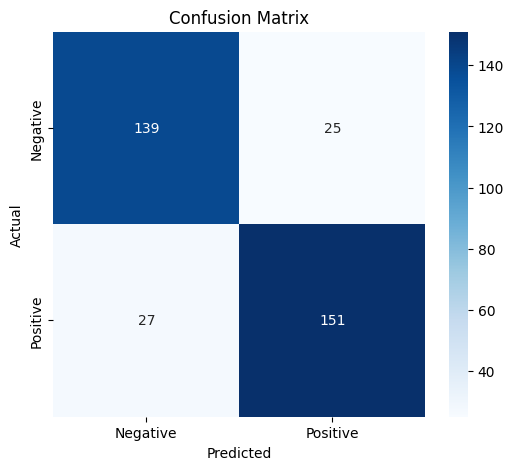

In [90]:
def evaluate_with_threshold(model, X_test, y_test, threshold=0.5):
    
    # Moving model and data to the appropriate device, if there is a processor mismatch.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test) # Ensuring the output is also on the correct device.
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # (Positive Class Probabilities)
        
        # Applying threshold to make predictions.
        y_pred = (probabilities > threshold).int()

    y_test_np = y_test.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, y_pred_np, average='binary')
    accuracy = accuracy_score(y_test_np, y_pred_np)

    # Printing the results:
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")

    # Visualization the results with Confusion Matrix:
    cm = confusion_matrix(y_test_np, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

evaluate_with_threshold(model, X_test, y_test, threshold=0.75)  # --------------> Change Threshold Value Here! <---------------

# BALANCED RNN - LSTM

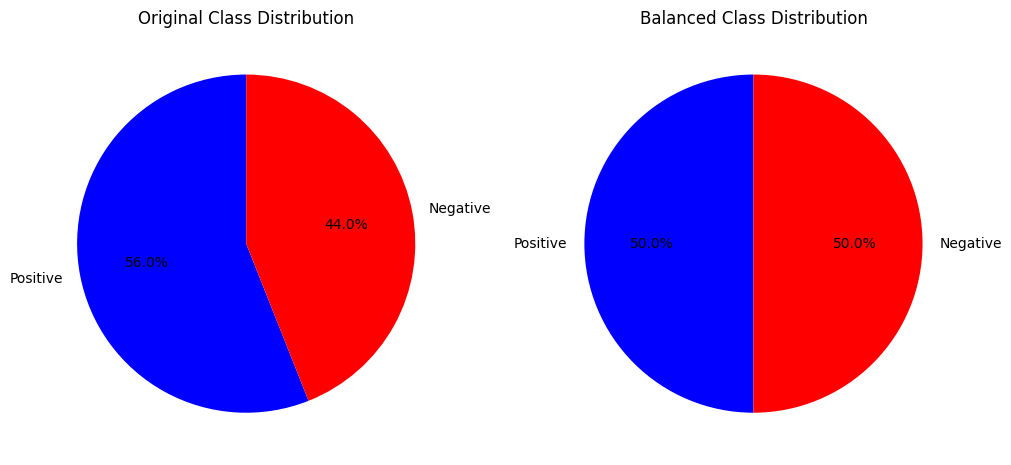

torch.Size([1364, 1, 768]) torch.Size([1364])
torch.Size([342, 1, 768]) torch.Size([342])
tensor([0, 1])
tensor([0, 1])


In [91]:
# Defining the RNN Model.
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        return out

file_path = 'pre_sentiment_data.csv'
df = pd.read_csv(file_path)

MODEL_NAME = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

# Data preparation with BERT model.
df["bert_embeddings"] = df["text"].apply(lambda x: get_average_embedding(x))
sentiment_mapping = {"pos": 1, "neg": 0}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)
X = torch.stack([torch.tensor(embed) for embed in df["bert_embeddings"].values]).unsqueeze(1)
y = torch.tensor(df["sentiment"].values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#-----------------------------------------------------------------------------------------------------#

# Geting the indexes that come with X_train and X_test.
train_indices, test_indices = train_test_split(df.index, test_size=0.2, random_state=42)

# Separating the training and test data via df.
df_train = df.loc[train_indices]
df_test = df.loc[test_indices]
original_distribution = df_train["sentiment"].value_counts()

# Balancing training data (oversampling with synthetic data).
df_majority = df_train[df_train["sentiment"] == 0]  # Negative Class
df_minority = df_train[df_train["sentiment"] == 1]  # Positive Class

df_minority_oversampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

# Merging the balanced dataset.
df_balanced_train = pd.concat([df_majority, df_minority_oversampled])

# Converting the balanced training data to Torch tensor.
X_train_balanced = torch.stack([torch.tensor(embed) for embed in df_balanced_train["bert_embeddings"].values])
y_train_balanced = torch.tensor(df_balanced_train["sentiment"].values, dtype=torch.long)

# Visualizing the distribution of classes:
def plot_class_distribution(original, balanced, labels=["Positive", "Negative"]):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].pie(original, labels=labels, autopct='%1.1f%%', startangle=90, colors=["blue", "red"])
    axs[0].set_title("Original Class Distribution")
    
    axs[1].pie(balanced, labels=labels, autopct='%1.1f%%', startangle=90, colors=["blue", "red"])
    axs[1].set_title("Balanced Class Distribution")
    
    plt.show()

original_counts = original_distribution.tolist()
balanced_counts = df_balanced_train["sentiment"].value_counts().tolist()
plot_class_distribution(original_counts, balanced_counts)

#-----------------------------------------------------------------------------------------------------#

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(y_train.unique())
print(y_test.unique())

# Defining layers, model, loss & optimizer.
input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = 2
model = RNNModel(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the RNN model.
def train_model(model, X_train, y_train, epochs=20, batch_size=32):
    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

In [92]:
train_model(model, X_train, y_train)

Epoch 1/20, Loss: 0.48190441727638245
Epoch 2/20, Loss: 0.4167608320713043
Epoch 3/20, Loss: 0.39203977584838867
Epoch 4/20, Loss: 0.35054174065589905
Epoch 5/20, Loss: 0.33566612005233765
Epoch 6/20, Loss: 0.31948938965797424
Epoch 7/20, Loss: 0.31133970618247986
Epoch 8/20, Loss: 0.30285385251045227
Epoch 9/20, Loss: 0.29282146692276
Epoch 10/20, Loss: 0.27883824706077576
Epoch 11/20, Loss: 0.2661007046699524
Epoch 12/20, Loss: 0.2559424042701721
Epoch 13/20, Loss: 0.24519725143909454
Epoch 14/20, Loss: 0.23598650097846985
Epoch 15/20, Loss: 0.231288343667984
Epoch 16/20, Loss: 0.219254732131958
Epoch 17/20, Loss: 0.21872758865356445
Epoch 18/20, Loss: 0.20874500274658203
Epoch 19/20, Loss: 0.1893395334482193
Epoch 20/20, Loss: 0.17163074016571045


Precision: 0.8896103896103896
Recall: 0.7696629213483146
F1 Score: 0.8253012048192772
Accuracy: 0.8304093567251462


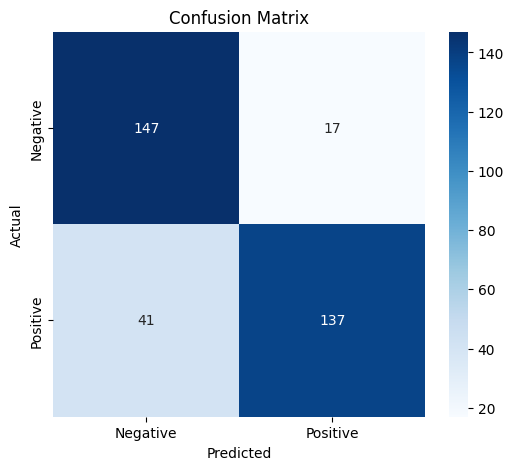

In [98]:
# Evaluating the RNN model with Balanced Dataset:
evaluate_with_threshold(model, X_test, y_test, threshold=0.73)  # --------------> Change Threshold Value Here! <---------------

# LOGISTIC REGRESSION CLASSIFICATION 

Accuracy on the test set: 0.8216374269005848
Precision: 0.916083916083916
Recall: 0.7359550561797753
F1 Score: 0.8161993769470405
Accuracy: 0.827485380116959


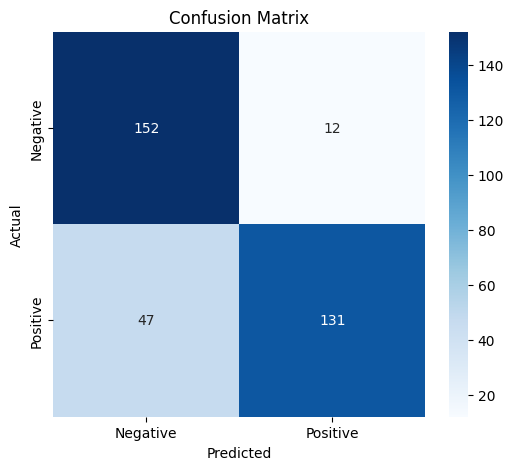

In [38]:
file_path = 'pre_sentiment_data.csv'
df = pd.read_csv(file_path)

MODEL_NAME = "dbmdz/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

# Data preparation with BERT model.
df["bert_embeddings"] = df["text"].apply(lambda x: get_average_embedding(x))
sentiment_mapping = {"pos": 1, "neg": 0}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)
X = list(df["bert_embeddings"]) 
y = torch.tensor(df["sentiment"].values, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting Train and Test sets to NumPy format.
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = y_train.numpy()
y_test_np = y_test.numpy()

# Creating and training the Logistic Regression model:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_np, y_train_np)

# Evaluation on the test set
y_pred = clf.predict(X_test_np)
accuracy = accuracy_score(y_test.numpy(), y_pred)
print(f"Accuracy on the test set: {accuracy}")

#-----------------------------------------------------------------------------------------------------#

# Evaluating the Logistic Regression model with the desired threshold value.
threshold = 0.7 # --------------> Change Threshold Value Here! <---------------

# Converting predictions to probability values for Logistic Regression.
y_pred_prob = clf.predict_proba(X_test_np)[:, 1]
y_pred_threshold = (y_pred_prob > threshold).astype(int)

# Precision, Recall & F1 Score calculation.
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, y_pred_threshold, average='binary')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Accuracy calculation.
accuracy = accuracy_score(y_test_np, y_pred_threshold)
print(f"Accuracy: {accuracy}")

# # Visualization the results with Confusion Matrix:
cm = confusion_matrix(y_test_np, y_pred_threshold)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()